In [1]:
import tensorflow as tf
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
save_path = 'data_omniglot/'

In [3]:
with open(os.path.join(save_path,"train.pickle"), "rb") as file:
    imgs_train = pickle.load(file)

In [4]:
with open(os.path.join(save_path,"val.pickle"), "rb") as file:
    imgs_validate = pickle.load(file)

In [7]:
def getbatch(imgs, batchsize):
    num_per_char = imgs[0].shape[0]
    diffchar = np.random.randint(0,2,batchsize)
    batch = np.zeros([2,batchsize,105,105,1])
    for i in range(batchsize):
        refchar = np.random.randint(964)
        refiter = np.random.randint(num_per_char)
        if diffchar[i] == 0:
            compchar = refchar
            compiter = np.random.choice(np.setdiff1d(np.arange(num_per_char),[refiter]))
        else:
            compchar = np.random.choice(np.setdiff1d(np.arange(964),[refchar]))
            compiter = np.random.randint(num_per_char)
        batch[0,i,:,:,0] = imgs[refchar][refiter]    
        batch[1,i,:,:,0] = imgs[compchar][compiter]  
    return batch, np.reshape(diffchar,[-1,1])

In [10]:
def convnet(inputs,reuse=False):

    with tf.variable_scope('conv1',reuse=reuse):
        conv1_1 = tf.layers.conv2d(inputs = inputs,
                                   filters = 64,
                                   kernel_size = 3,
                                   strides = [1,1],
                                   padding = 'SAME',
                                   activation = tf.nn.relu)
        
    pool1 = tf.layers.max_pooling2d(inputs = conv1_1,
                                    pool_size = 2,
                                    strides = 2,
                                    padding = 'VALID')
    
    with tf.variable_scope('conv2',reuse=reuse):
        conv2 = tf.layers.conv2d(inputs = pool1,
                                   filters = 128,
                                   kernel_size = 3,
                                   strides = [1,1],
                                   padding = 'SAME',
                                   activation = tf.nn.relu)

    pool2 = tf.layers.max_pooling2d(inputs = conv2,
                                    pool_size = 2,
                                    strides = 2,
                                    padding = 'VALID')
    
    with tf.variable_scope('conv3',reuse=reuse):
        conv3 = tf.layers.conv2d(inputs = pool2,
                                   filters = 256,
                                   kernel_size = 3,
                                   strides = [1,1],
                                   padding = 'SAME',
                                   activation = tf.nn.relu)
        
    pool3 = tf.layers.max_pooling2d(inputs = conv3,
                                    pool_size = 2,
                                    strides = 2,
                                    padding = 'VALID')

    with tf.variable_scope('conv4',reuse=reuse):
        conv4 = tf.layers.conv2d(inputs = pool3,
                                   filters = 512,
                                   kernel_size = 3,
                                   strides = [1,1],
                                   padding = 'SAME',
                                   activation = tf.nn.relu)

    pool4 = tf.layers.max_pooling2d(inputs = conv4,
                                    pool_size = 2,
                                    strides = 2,
                                    padding = 'VALID')
    
    with tf.variable_scope('conv5',reuse=reuse):
        conv5 = tf.layers.conv2d(inputs = pool4,
                                   filters = 512,
                                   kernel_size = 6,
                                   strides = [1,1],
                                   padding = 'VALID',
                                   activation = tf.nn.relu)
    
    flat = tf.layers.flatten(conv5)
    
    
    with tf.variable_scope('fc',reuse=reuse):
        features = tf.layers.dense(inputs=flat, use_bias=False, units=2048, activation=tf.nn.sigmoid)

    return features

In [11]:
tf.reset_default_graph()

In [12]:
img1 = tf.placeholder(tf.float32, shape=[None, 105, 105, 1])
img2 = tf.placeholder(tf.float32, shape=[None, 105, 105, 1])
diffclass = tf.placeholder(tf.float32, shape=[None,1])

In [13]:
m = 1

features1 = convnet(img1, reuse=False)
features2 = convnet(img2, reuse=True)

diff = tf.sqrt(tf.reduce_mean(tf.square(features1 - features2),axis=1))
diff = tf.reshape(diff,[-1,1])

loss = tf.reduce_mean((1-diffclass)*diff**2 / 2 + diffclass*(tf.maximum(0.,m-diff))**2/2)

opt = tf.train.AdamOptimizer(
        learning_rate = 0.0001)
train_op = opt.minimize(loss)

In [14]:
saver = tf.train.Saver()

In [15]:
batchsize = 64
trainsteps = 5000
printstep = 500
l = np.zeros(trainsteps)
acc = np.zeros(trainsteps)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(trainsteps):
        batch, batch_diff = getbatch(imgs_train, batchsize)
        _,l[step] = sess.run([train_op,loss], feed_dict={img1: batch[0,:,:,:,:],
                                               img2: batch[1,:,:,:,:],
                                               diffclass: batch_diff})
        if ((step+1)%printstep==0):
            print('Step %d: Loss %f, Accuracy %f' % (step,np.mean(l[step-printstep+1:step+1]),
                                                     np.mean(acc[step-printstep+1:step+1])))
            
    saver.save(sess, './checkpoints/model', step)
#         print(np.matrix([p[:,0],batch_diff[:,0]]))

Step 499: Loss 0.083418, Accuracy 0.000000
Step 999: Loss 0.066209, Accuracy 0.000000
Step 1499: Loss 0.059409, Accuracy 0.000000
Step 1999: Loss 0.054738, Accuracy 0.000000
Step 2499: Loss 0.051614, Accuracy 0.000000
Step 2999: Loss 0.049195, Accuracy 0.000000
Step 3499: Loss 0.046991, Accuracy 0.000000
Step 3999: Loss 0.045051, Accuracy 0.000000
Step 4499: Loss 0.042808, Accuracy 0.000000
Step 4999: Loss 0.041114, Accuracy 0.000000


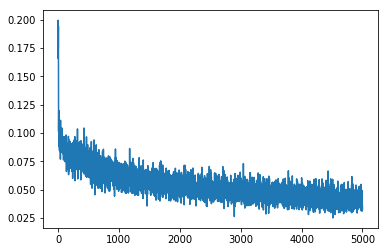

In [16]:
plt.plot(l)

In [15]:
ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/model'))

## compare image 0 to images 15-19 and find closest match

In [69]:
num_compare = 5

In [89]:
find_img = 127

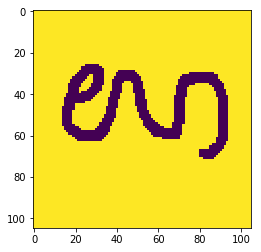

In [90]:
plt.imshow(imgs_validate[find_img,0,:,:])
plt.show()

In [91]:
with tf.Session() as sess:
    saver.restore(sess, ckpt.model_checkpoint_path)
    diff_val=np.zeros([imgs_validate.shape[0],num_compare])
    for i in range(imgs_validate.shape[0]):
        for j in range(20-num_compare,20):
            diff_val[i][j-20+num_compare] = sess.run(diff, feed_dict={
                img1: np.reshape(imgs_validate[find_img,0,:,:],[1,105,105,1]),
                img2: np.reshape(imgs_validate[i,j,:,:],[1,105,105,1])})

INFO:tensorflow:Restoring parameters from checkpoints/model-4999


In [92]:
closest_match = np.argmin(np.mean(diff_val,1))
print(closest_match)

127


In [93]:
print(diff_val[find_img])
print(diff_val[closest_match])

[0.06533433 0.08978902 0.21901157 0.09537154 0.13986298]
[0.06533433 0.08978902 0.21901157 0.09537154 0.13986298]


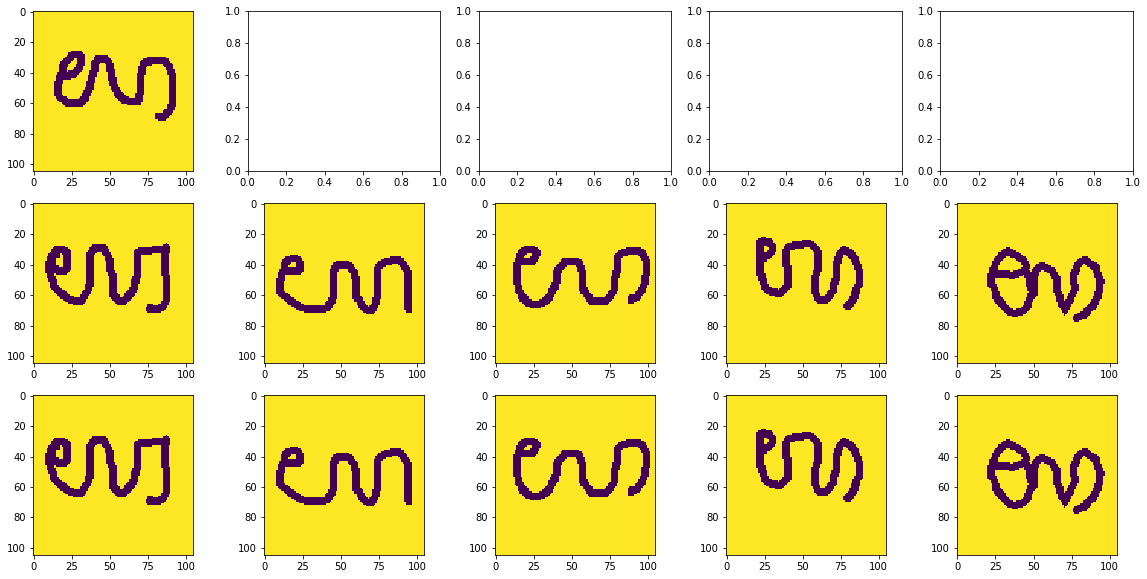

In [94]:
fig, ax = plt.subplots(3,num_compare,figsize=(20,10))
ax[0,0].imshow(imgs_validate[find_img,0,:,:])
for i in range(20-num_compare,20):
    ax[1,i-20+num_compare].imshow(imgs_validate[find_img,i,:,:])
    ax[2,i-20+num_compare].imshow(imgs_validate[closest_match,i,:,:])  
plt.show()